# Keras finance prediction model 
### Author Petri Lamminaho 
### Simple stock prediction model uses Keras machine learning lib


In [1]:
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime as dt
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

c:\users\petri\anaconda3\envs\tf1.6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_market_data(stock_name, normalized=0):# reads data from 
    start_day = dt.datetime(2010, 1, 1)  # starting day 
    end_day = dt.datetime.now()  # end day (today) 
    df = pdr.DataReader(stock_name, 'yahoo', start_day, end_day)  #
    df = df[["Open", "High", "Close"]]  # 
    #print(df.tail())
    return df

In [3]:
def pre_process_data(df, f=1000):# normalazing data 
    df['High'] = df['High'] / f
    df['Open'] = df['Open'] / f
    df['Close'] = df['Close'] / f
    print("Start:",df.head())
    print("End:",df.tail())
    return  df


In [4]:
def save_data_to_csv(df, stock_name): # saves data to csv file 
    file_name = stock_name + '.csv'
    df.to_csv(file_name)

In [6]:
def train_test_split(stocks, seq_len):

    num_of_features = len(stocks.columns)
    data = stocks.as_matrix()
    print("First data", data[0])
    print("last data", data[-1])
    len_of_seq = seq_len + 1
    res =[]
    for i in range(len(data)- len_of_seq):
        res.append(data[i: i +len_of_seq])

    res = np.array(res)
    row = round(0.9 * res.shape[0])
    train = res[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:, -1]
    x_test = res[int(row):, :-1]
    y_test = res[int(row):, -1][:, -1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_of_features))
    return [x_train, y_train, x_test, y_test]


In [8]:
def build_model(layers): # building Keras RNN model 
    drop = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(drop))
    
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(drop))
    
    model.add(Dense(16, init='uniform', activation='relu'))
    model.add(Dense(1, init='uniform', activation='relu'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
stock_name = 'GOOGL'
df = get_market_data(stock_name,0)
df = pre_process_data(df, 1000)
save_data_to_csv(df, stock_name)
window = 5
X_train, y_train, X_test, y_test = train_test_split(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
model = build_model([3,window,1])

model.fit(  # training 
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=500,
    validation_split=0.1,
    verbose=0)

Start:                 Open      High     Close
Date                                    
2010-01-04  0.313789  0.315070  0.313689
2010-01-05  0.313904  0.314234  0.312307
2010-01-06  0.313243  0.313243  0.304434
2010-01-07  0.305005  0.305305  0.297347
2010-01-08  0.296296  0.301927  0.301311
End:                Open     High    Close
Date                                 
2019-01-28  1.09007  1.09337  1.07986
2019-01-29  1.08104  1.08473  1.07006
2019-01-30  1.07736  1.09952  1.09799
2019-01-31  1.11224  1.12767  1.12589
2019-02-01  1.12229  1.13440  1.11862
First data [0.31378879 0.31507007 0.31368869]
last data [1.12229004 1.13440002 1.11862   ]
X_train (2052, 5, 3)
y_train (2052,)
X_test (228, 5, 3)
y_test (228,)


c:\users\petri\anaconda3\envs\tf1.6\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, kernel_initializer="uniform", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\petri\anaconda3\envs\tf1.6\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", activation="relu")`
  if sys.path[0] == '':
c:\users\petri\anaconda3\envs\tf1.6\lib\site-packages\keras\models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [10]:
trainScore = model.evaluate(X_train, y_train, verbose=0)# testing and prints model acc 
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

print(X_test[0])
diff=[]
ratio=[]
p = model.predict(X_test)


for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))


Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.04 RMSE)
[[1.122      1.12765002 1.10392004]
 [1.10954004 1.11127002 1.07141003]
 [1.05797998 1.08689001 1.08414001]
 [1.07813    1.10118005 1.09476001]
 [1.10209998 1.10563    1.10090002]]


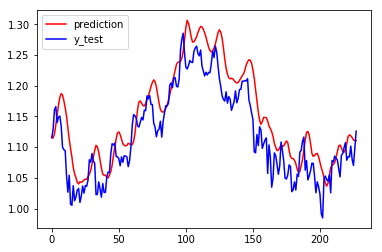

In [13]:
plt.plot(p, color='red', label='prediction') # plotting results 
plt.plot(y_test, color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()